In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
#Load the dataset
df = pd.read_json('electronics.json')

In [26]:
# 1. Handle Missing Values
df = df.dropna(subset=['Customer_ID'])  # Drop rows with missing Customer_ID
df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'], errors='coerce')
df = df.dropna(subset=['Purchase_Date'])  # Drop rows with missing Purchase_Date

In [27]:
#Convert numerical columns to numeric type
columns_to_numeric = ['Age', 'Purchase_Amount', 'Average_Spending_Per_Purchase', 
                      'Purchase_Frequency_Per_Month', 'Brand_Affinity_Score', 'Month', 'Year', 'Will_Purchase_Next_Month']
df[columns_to_numeric] = df[columns_to_numeric].apply(pd.to_numeric, errors='coerce')

In [28]:
#Handle missing values for numerical columns with median (for numerical columns)
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Purchase_Amount'] = df['Purchase_Amount'].fillna(df['Purchase_Amount'].median())
df['Average_Spending_Per_Purchase'] = df['Average_Spending_Per_Purchase'].fillna(df['Average_Spending_Per_Purchase'].median())
df['Purchase_Frequency_Per_Month'] = df['Purchase_Frequency_Per_Month'].fillna(df['Purchase_Frequency_Per_Month'].mean())
df['Brand_Affinity_Score'] = df['Brand_Affinity_Score'].fillna(df['Brand_Affinity_Score'].mean())
df['Will_Purchase_Next_Month'] = df['Will_Purchase_Next_Month'].fillna(df['Will_Purchase_Next_Month'].mode()[0])

In [29]:
#Handle missing values in categorical columns
df['Customer_ID'] = df['Customer_ID'].replace('Hidden', '')
df['Product_ID'] = df['Product_ID'].replace('Hidden', '')
df['Season'] = df['Season'].replace('Hidden', np.nan).replace('', np.nan).fillna(df['Season'].mode()[0])

In [30]:
#Handle missing values for Year and Month from Purchase_Date
df['Year'] = df['Purchase_Date'].dt.year
df['Month'] = df['Purchase_Date'].dt.month

In [31]:
# 2.Handle Outliers for Numerical Columns (using IQR method)
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

In [32]:
#Apply outlier treatment for specific columns
handle_outliers(df, 'Age')
handle_outliers(df, 'Purchase_Amount')
handle_outliers(df, 'Average_Spending_Per_Purchase')

In [33]:
# 3. Feature Engineering
# Product Category Score (aggregated at product category level)
category_avg = df.groupby('Product_Category')['Purchase_Amount'].transform('mean')
df['Product_Category_Score'] = df['Purchase_Amount'] / category_avg

#Seasonal Purchase Trend Indicator (focused on Electronics)
df['Seasonal_Purchase_Trend_Indicator'] = df.apply(
    lambda row: 1 if row['Product_Category'] == 'Electronics' and row['Season'] in ['Winter', 'Spring', 'Summer', 'Fall'] else 0, axis=1
)

#Aggregate the Seasonal Purchase Trend Indicator at the product category level
df['Seasonal_Purchase_Trend_Indicator'] = df.groupby('Product_Category')['Seasonal_Purchase_Trend_Indicator'].transform('mean')

#Apply threshold to determine dominant high-demand season
df['Seasonal_Purchase_Trend_Indicator'] = df['Seasonal_Purchase_Trend_Indicator'].apply(lambda x: 1 if x > 0 else 0)

#Spending Efficiency Ratio (aggregated at product category level)
df['Spending_Efficiency_Ratio'] = df.groupby('Product_Category')['Purchase_Amount'].transform('sum') / \
                                  df.groupby('Product_Category')['Average_Spending_Per_Purchase'].transform('sum')

#Handle outliers for Spending_Efficiency_Ratio
handle_outliers(df, 'Spending_Efficiency_Ratio')


In [34]:
# 4. Feature Encoding
# One-Hot Encoding for Nominal Variables like 'Product_Category', 'Season'
df = pd.get_dummies(df, columns=['Product_Category', 'Season'], drop_first=True)

#Label Encoding for Ordinal Variables like 'Income_Level' (if applicable)
le = LabelEncoder()
df['Income_Level'] = le.fit_transform(df['Income_Level'])


In [35]:

# 5. Feature Scaling (Standardization)
#Standardize numerical columns
columns_to_standardize = ['Age', 'Purchase_Amount', 'Average_Spending_Per_Purchase', 'Purchase_Frequency_Per_Month', 
                          'Brand_Affinity_Score', 'Product_Category_Score', 'Spending_Efficiency_Ratio']
scaler = StandardScaler()
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])


In [36]:
# 6. Split Data into Features and Target
#Define target variable y and feature set X
X = df.drop(columns=['Purchase_Amount', 'Customer_ID', 'Product_ID'])  # Drop 'Customer_ID', 'Product_ID', and target variable
y = df['Purchase_Amount']

#Check for non-numeric columns
print("Columns in X before encoding:", X.columns)

#Ensure that all columns in X are numeric
X = X.select_dtypes(include=[np.number])  # Keep only numeric columns in X

#Check the shape of X to make sure it's now numeric
print("Columns in X after selecting numeric:", X.columns)

Columns in X before encoding: Index(['Age', 'Gender', 'Income_Level', 'Address', 'Transaction_ID',
       'Purchase_Date', 'Brand', 'Average_Spending_Per_Purchase',
       'Purchase_Frequency_Per_Month', 'Brand_Affinity_Score',
       'Product_Category_Preferences', 'Month', 'Year',
       'Will_Purchase_Next_Month', 'Product_Category_Score',
       'Seasonal_Purchase_Trend_Indicator', 'Spending_Efficiency_Ratio',
       'Product_Category_Books', 'Product_Category_Clothing',
       'Product_Category_Electronics', 'Product_Category_Hidden',
       'Season_Spring', 'Season_Summer', 'Season_Winter'],
      dtype='object')
Columns in X after selecting numeric: Index(['Age', 'Income_Level', 'Average_Spending_Per_Purchase',
       'Purchase_Frequency_Per_Month', 'Brand_Affinity_Score', 'Month', 'Year',
       'Will_Purchase_Next_Month', 'Product_Category_Score',
       'Seasonal_Purchase_Trend_Indicator', 'Spending_Efficiency_Ratio'],
      dtype='object')


In [37]:
df.head()

,Customer_ID,Age,Gender,Income_Level,Address,Transaction_ID,Purchase_Date,Product_ID,Brand,Purchase_Amount,...,Product_Category_Score,Seasonal_Purchase_Trend_Indicator,Spending_Efficiency_Ratio,Product_Category_Books,Product_Category_Clothing,Product_Category_Electronics,Product_Category_Hidden,Season_Spring,Season_Summer,Season_Winter
0,b81ee6c9-2ae4-48a7-b283-220eaa244f43,-0.540511,Female,4,"43548 Murray Islands Suite 974\nAmyberg, CT 13457",c6a6c712-e36b-406a-bfde-f53bdcf4744f,2022-04-26,d2f767d6-b01a-41a2-87f7-ec1d1186f50e,Brand_C,-0.413109,...,-0.462696,0,-1.095497,False,True,False,False,False,False,True
1,,-1.362765,Male,2,,0b587838-1e4f-4231-b488-42bcd47c052a,2021-08-10,79eadc55-2de1-41cf-b1b6-40118c0bf8ec,Brand_A,0.491714,...,0.466227,0,0.378259,True,False,False,False,False,False,False
2,fdf79bcd-5908-4c90-8501-570ffb5b7648,0.391377,Other,3,"79683 Kevin Hill Apt. 555\nJohnshire, AR 39961",462925b1-a5bf-4996-bda2-59749de64eea,2021-12-09,9ab75a68-4329-4bd9-a259-2233c0f34c93,Brand_A,-0.384154,...,-0.328144,1,0.464564,False,False,True,False,False,False,True
3,878dccba-893a-48f9-8d34-6ed394fa3c9c,-0.650145,Female,4,02998 Hall Meadows Suite 809\nNorth Robertvill...,3cfafa02-6b34-4d77-9e05-d223dfab64e8,2022-12-03,d518569b-ff79-494b-b2b6-7e2af39db86a,Brand_C,0.086354,...,0.019600,0,-1.095497,False,True,False,False,False,False,False
4,0af0bd81-73cc-494e-aa5e-75c6d0b6d743,0.994363,Other,4,"21411 Timothy Ford Apt. 320\nDavisborough, AR ...",0d8dc27a-0c8f-4a82-b57e-8bf54cee9759,2020-06-08,b6deac9d-2b7e-4a51-8273-a6534910b3bc,Brand_B,1.295197,...,1.261362,0,0.378259,True,False,False,False,False,True,False


In [38]:
# 7. Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (761, 11) (761,)
Testing set shape: (191, 11) (191,)


In [39]:
# 8. Train the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# 9. Make Predictions on the Test Set
y_pred = model.predict(X_test)


In [40]:
# 10. Evaluate the Model
print("R-squared:", r2_score(y_test, y_pred))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))

R-squared: 0.9985649844697778
Mean Absolute Error (MAE): 0.031210244695332002
Mean Squared Error (MSE): 0.0014804432993290031


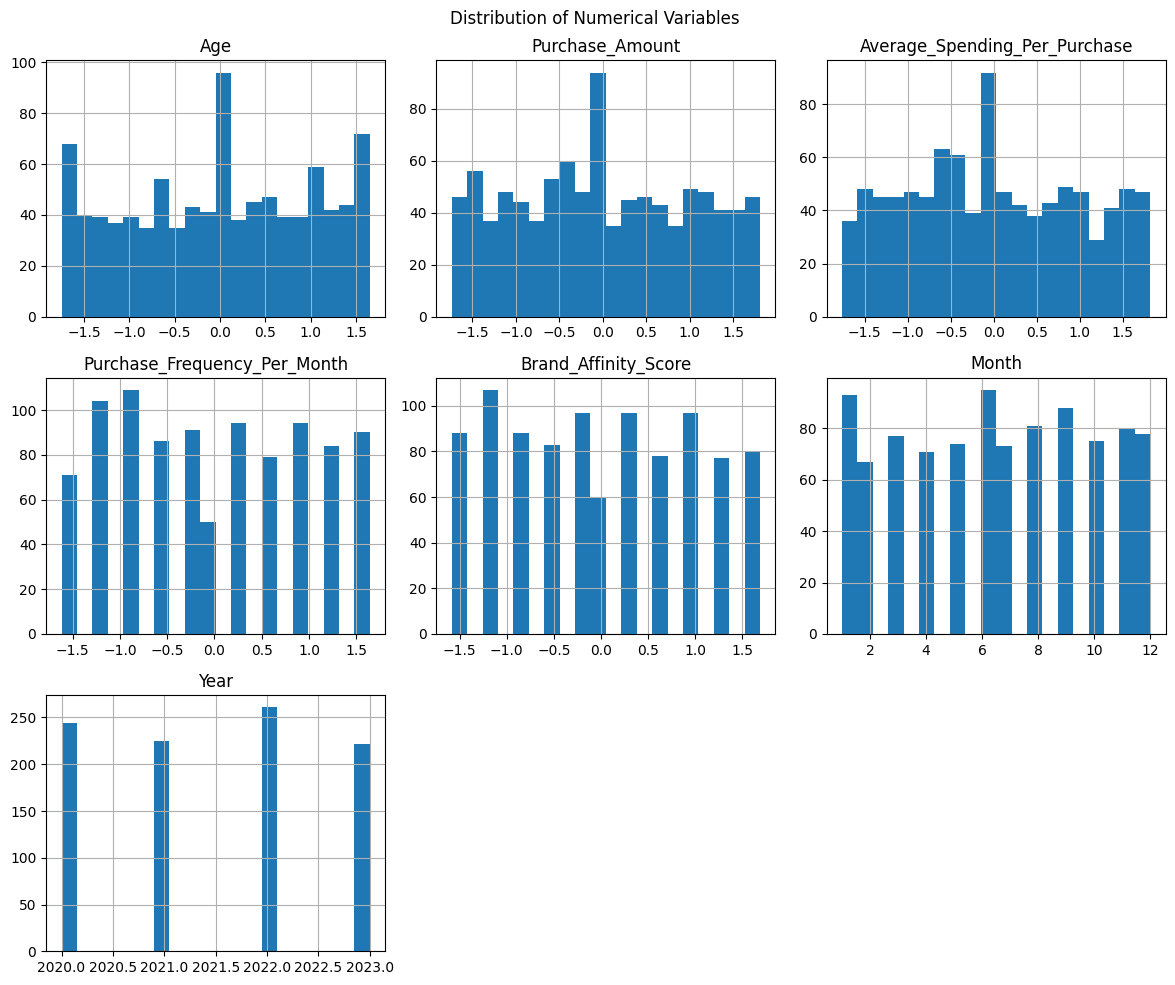

In [41]:
# 1. Distribution of Numerical Variables
#Plot histograms for all numeric columns to check distributions
numeric_columns = ['Age', 'Purchase_Amount', 'Average_Spending_Per_Purchase', 
                   'Purchase_Frequency_Per_Month', 'Brand_Affinity_Score', 'Month', 'Year']

df[numeric_columns].hist(figsize=(12, 10), bins=20)
plt.suptitle('Distribution of Numerical Variables')
plt.tight_layout()
plt.show()

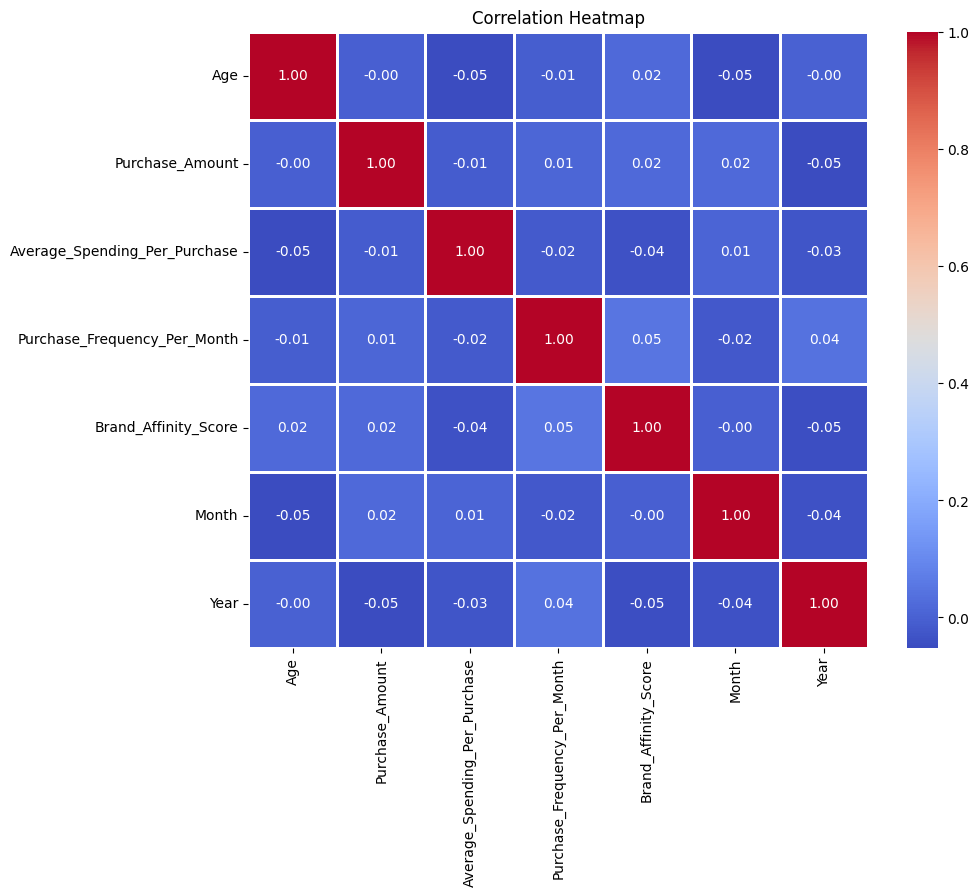

In [42]:
# 2. Correlation Heatmap
#Show correlation matrix of numerical columns
corr = df[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1, cbar=True)
plt.title('Correlation Heatmap')
plt.show()


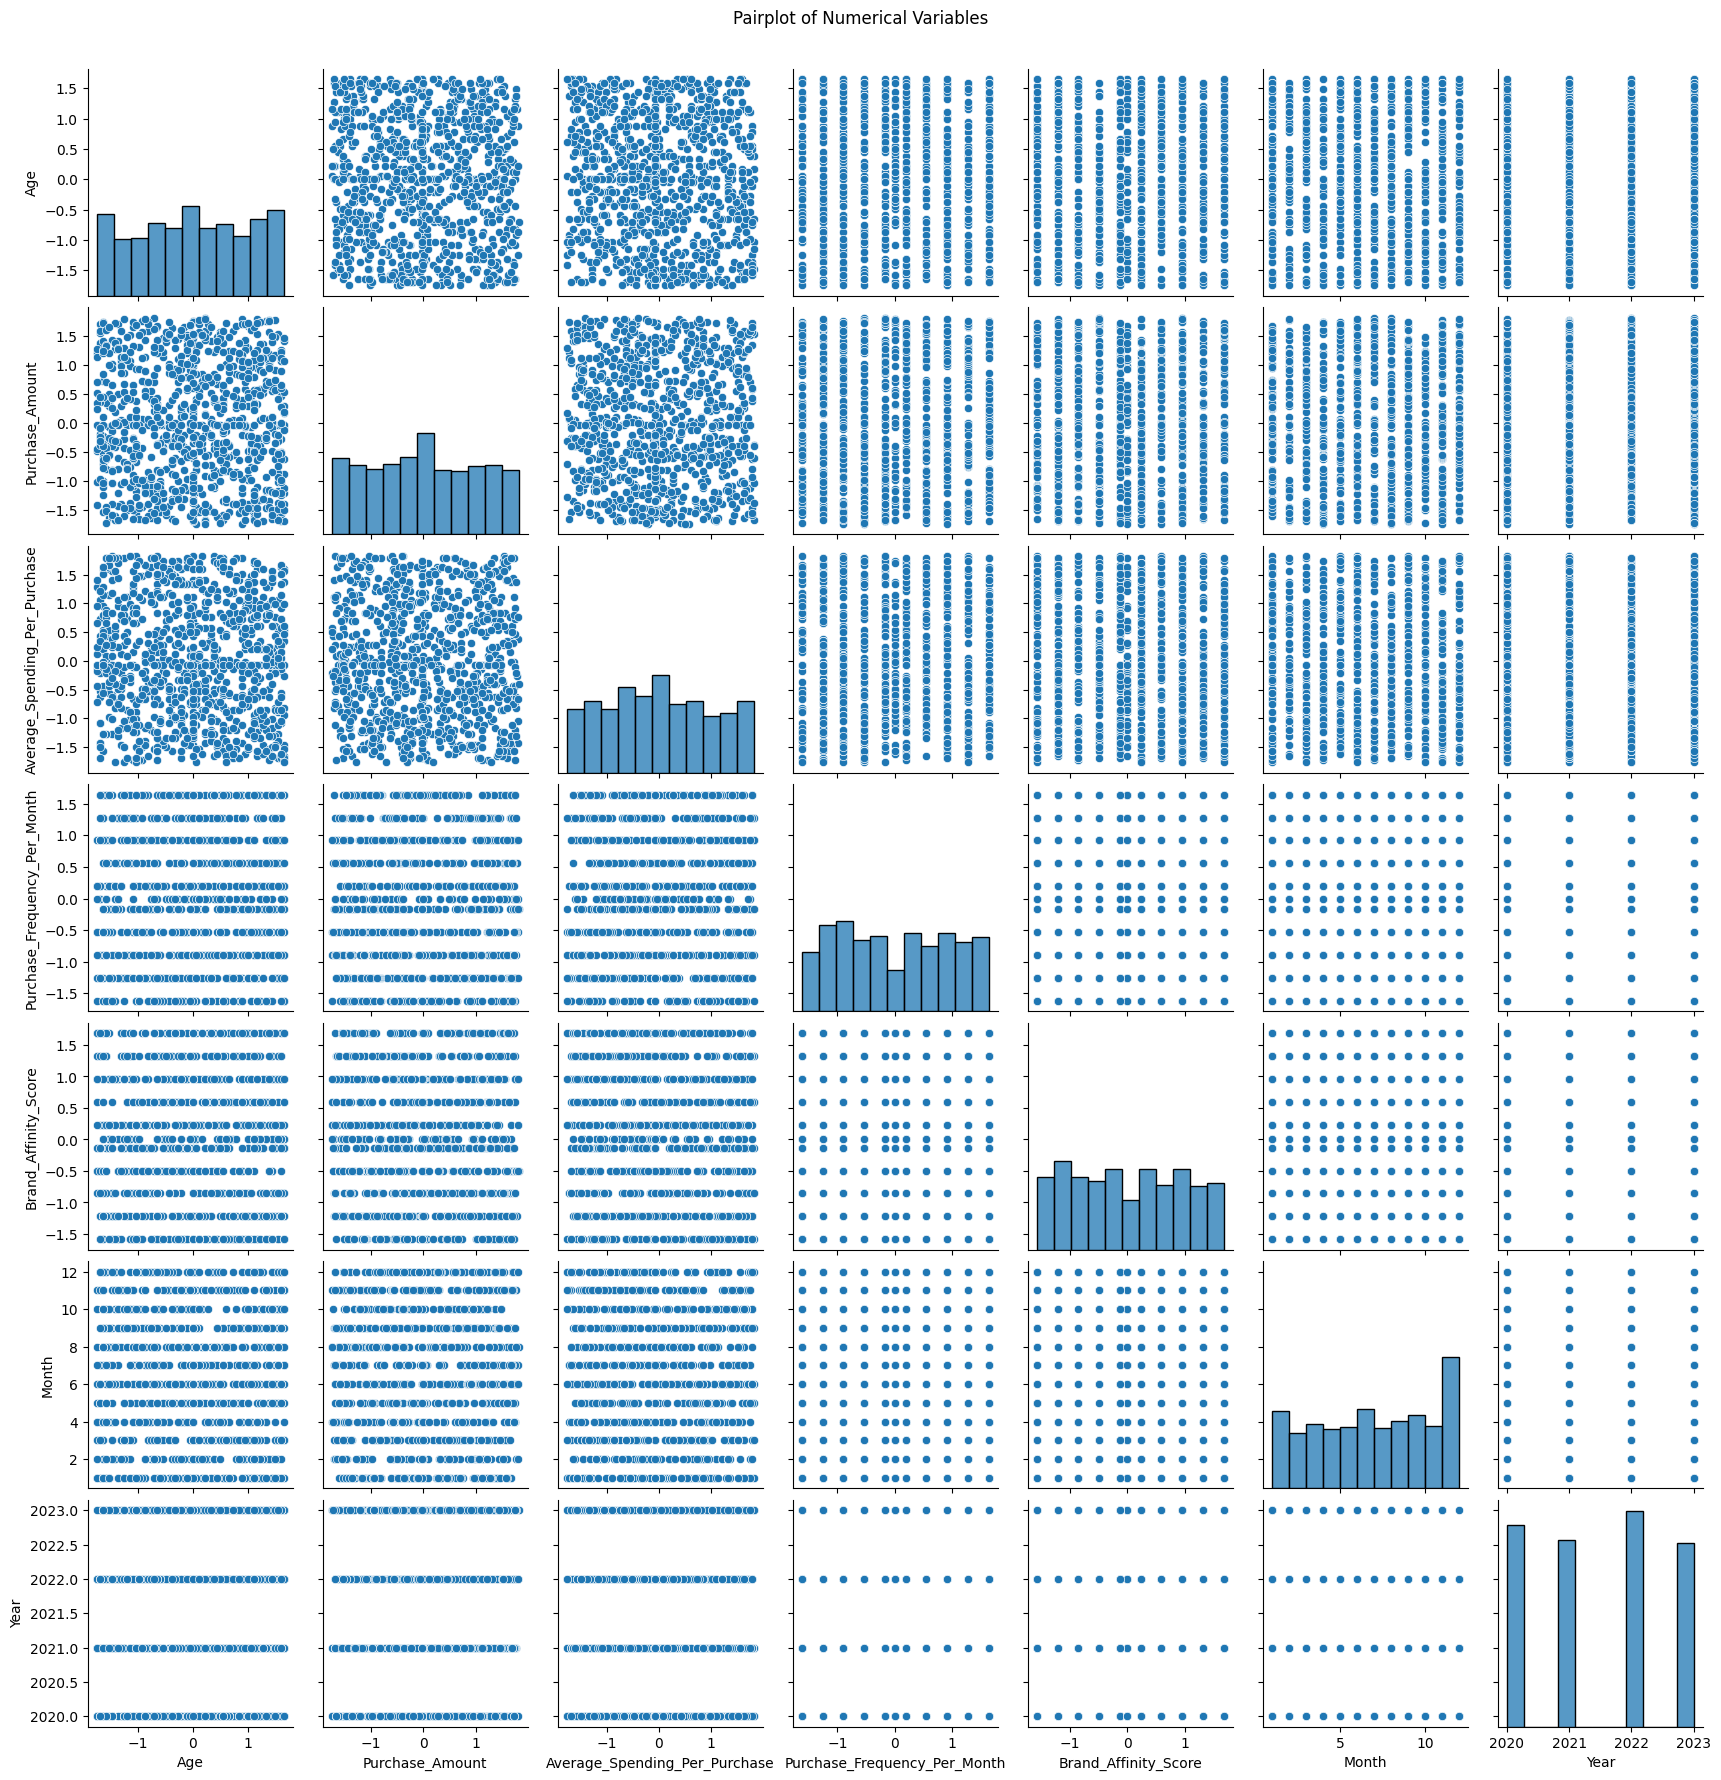

In [43]:
# 3. Pairplot of Numerical Columns
#Visualize relationships between numerical variables using scatterplots
sns.pairplot(df[numeric_columns])
plt.suptitle('Pairplot of Numerical Variables', y=1.02)
plt.show()

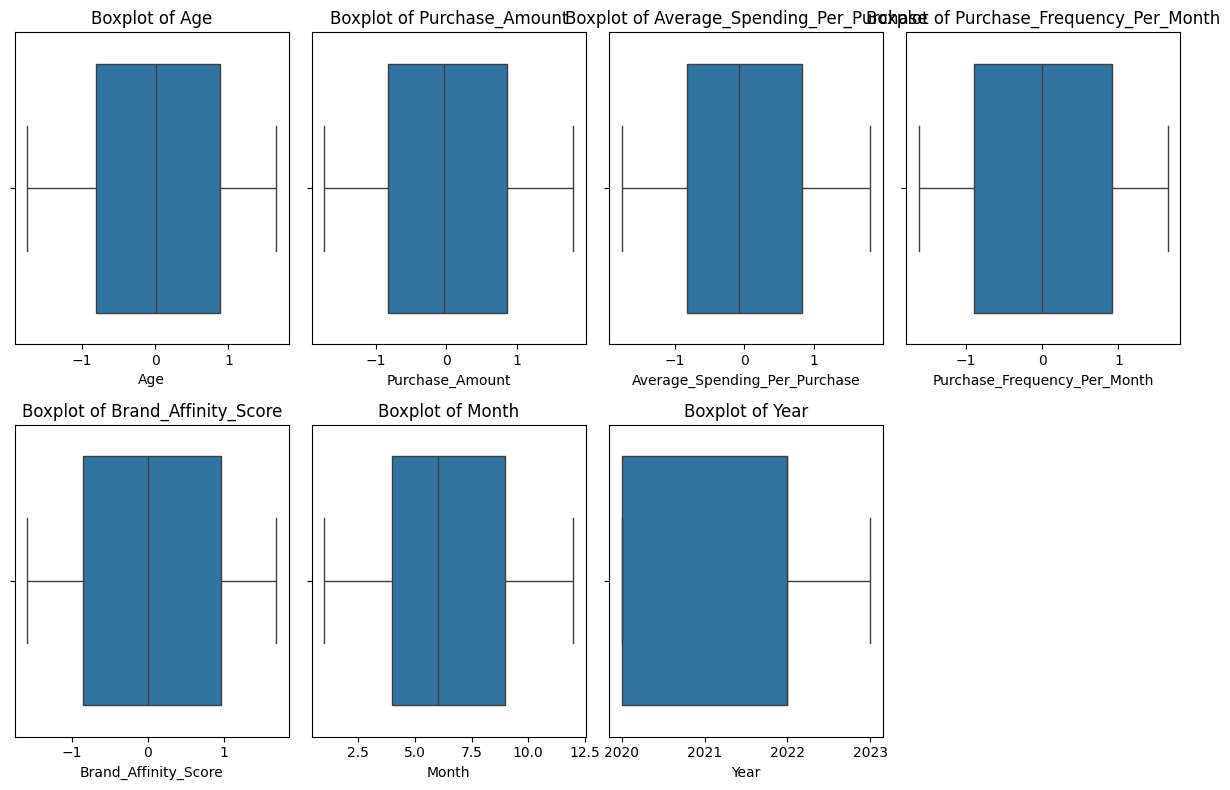

In [44]:
# 4. Boxplots to Check for Outliers (for specific columns)
#Check for outliers in specific numerical features using boxplots
plt.figure(figsize=(12, 8))

#Loop over selected numerical columns to create boxplots
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

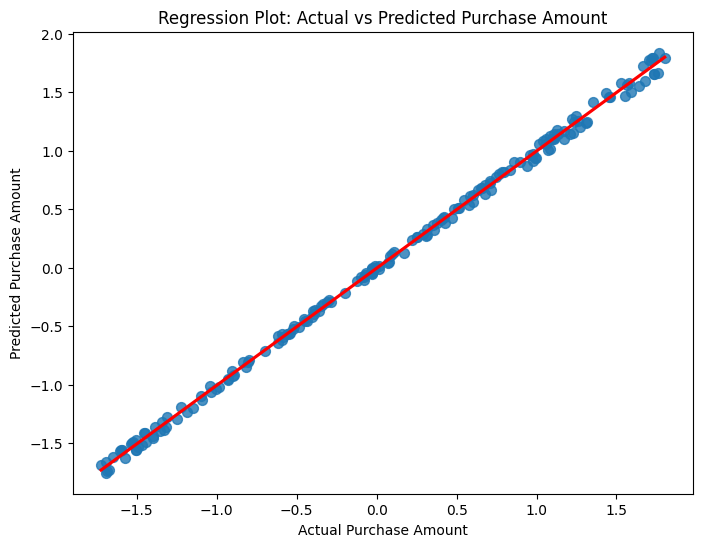

In [45]:
# 5. Regression Plot: Predicted vs Actual
#Compare model predictions vs actual values for the test set

plt.figure(figsize=(8, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Regression Plot: Actual vs Predicted Purchase Amount')
plt.xlabel('Actual Purchase Amount')
plt.ylabel('Predicted Purchase Amount')
plt.show()

In [46]:
df.to_csv('processed_dataset.csv', index=False)

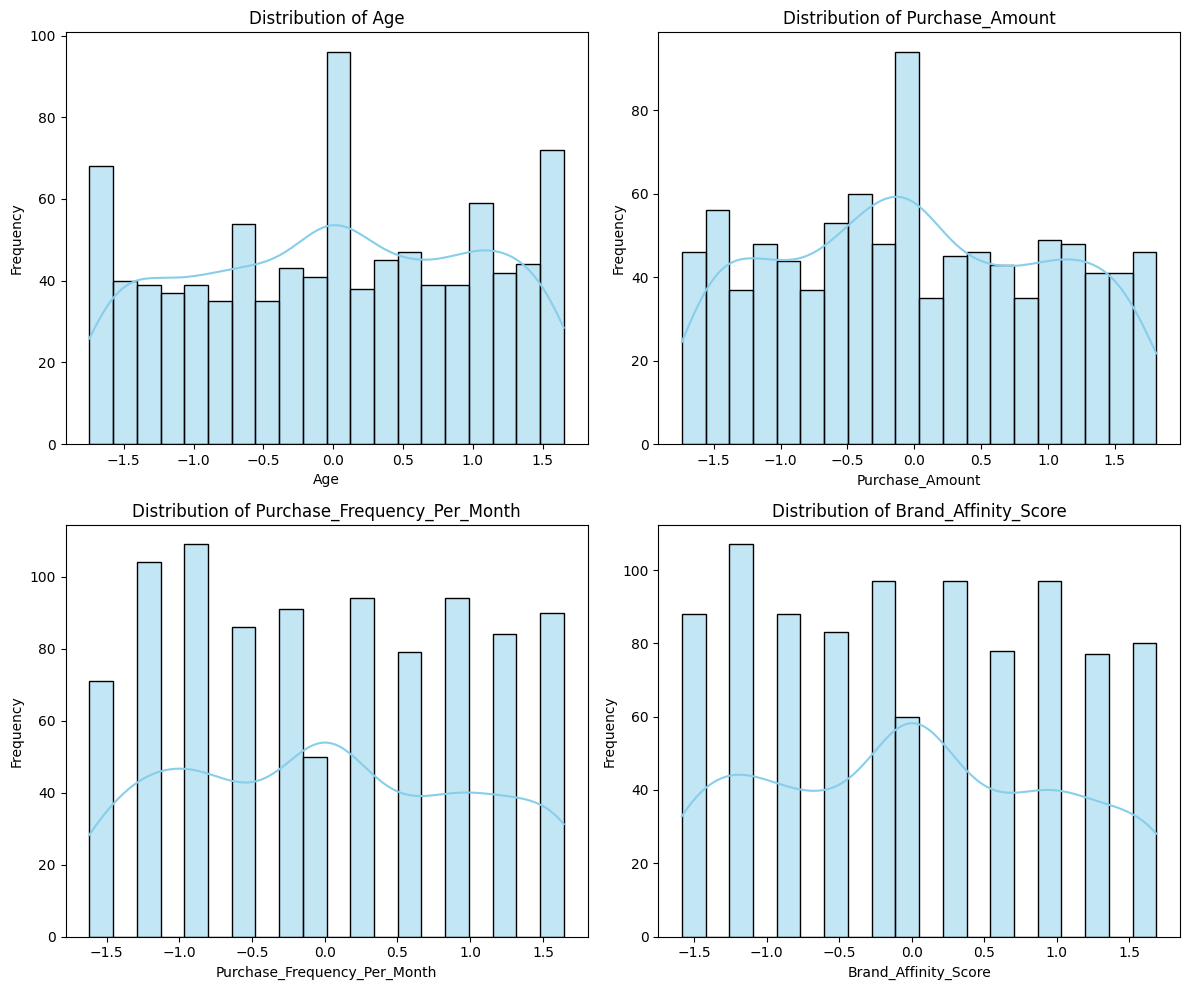

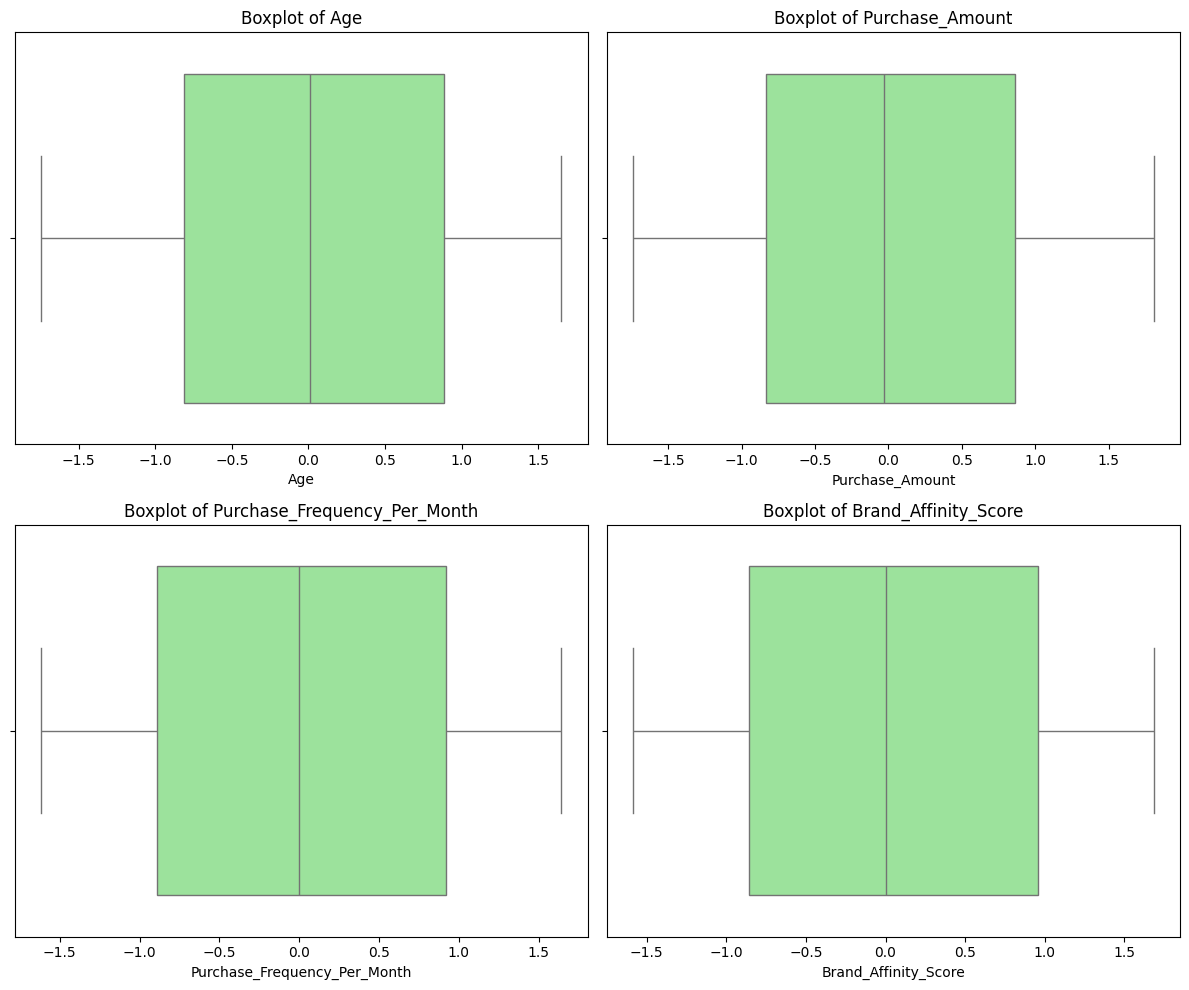

Descriptive Statistics for Key Features:
                Age  Purchase_Amount  Purchase_Frequency_Per_Month  \
count  9.520000e+02     9.520000e+02                  9.520000e+02   
mean   4.478211e-17    -6.344132e-17                 -5.597763e-17   
std    1.000526e+00     1.000526e+00                  1.000526e+00   
min   -1.746483e+00    -1.737770e+00                 -1.618375e+00   
25%   -8.145956e-01    -8.329466e-01                 -8.935618e-01   
50%    7.658246e-03    -2.946377e-02                  0.000000e+00   
75%    8.847290e-01     8.608821e-01                  9.184723e-01   
max    1.652166e+00     1.809137e+00                  1.643286e+00   

       Brand_Affinity_Score  
count          9.520000e+02  
mean          -6.530724e-17  
std            1.000526e+00  
min           -1.584371e+00  
25%           -8.573858e-01  
50%            0.000000e+00  
75%            9.600765e-01  
max            1.687061e+00  

Skewness of Key Features:
Age                            

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Univariate Analysis: Distribution of Key Features (e.g., 'Age', 'Purchase_Amount', 'Purchase_Frequency_Per_Month')

# Numeric columns to analyze
numeric_columns = ['Age', 'Purchase_Amount', 'Purchase_Frequency_Per_Month', 'Brand_Affinity_Score']

# Histograms for each numeric feature
plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True, bins=20, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Boxplots for each numeric feature (to identify outliers)
plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

# Descriptive Statistics for key features
print("Descriptive Statistics for Key Features:")
print(df[numeric_columns].describe())

# Check for Skewness
print("\nSkewness of Key Features:")
print(df[numeric_columns].skew())


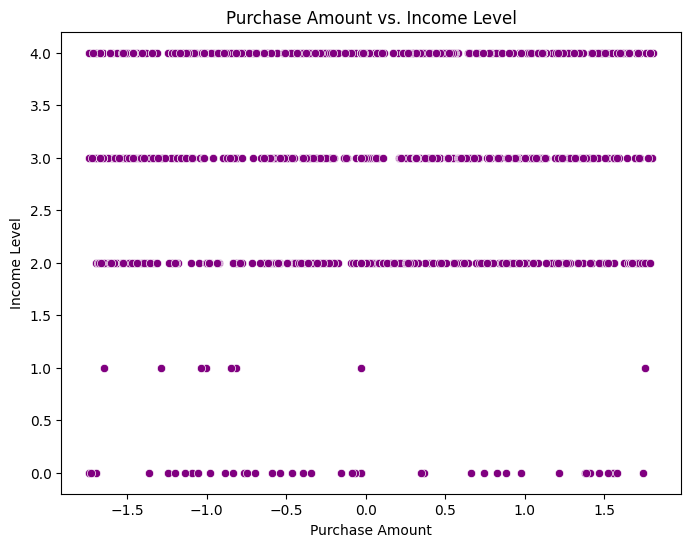

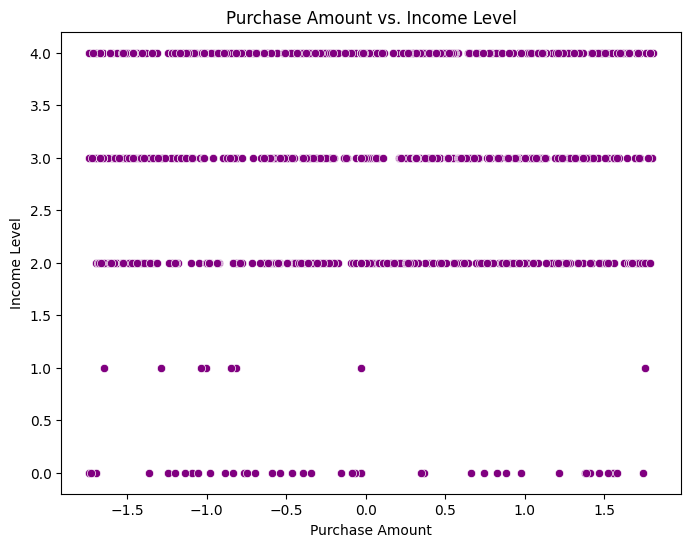

C:\Users\Muneeb\AppData\Local\Temp\ipykernel_6548\3283959228.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Product_Category_Electronics'], y=df['Brand_Affinity_Score'], palette='Set2')


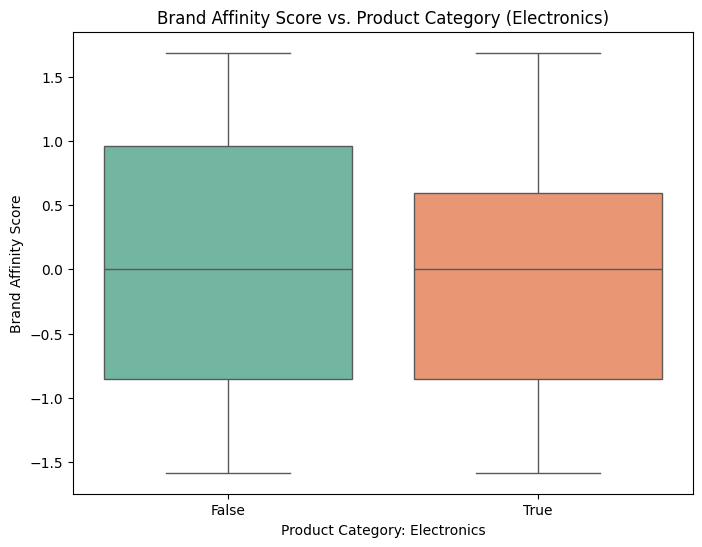

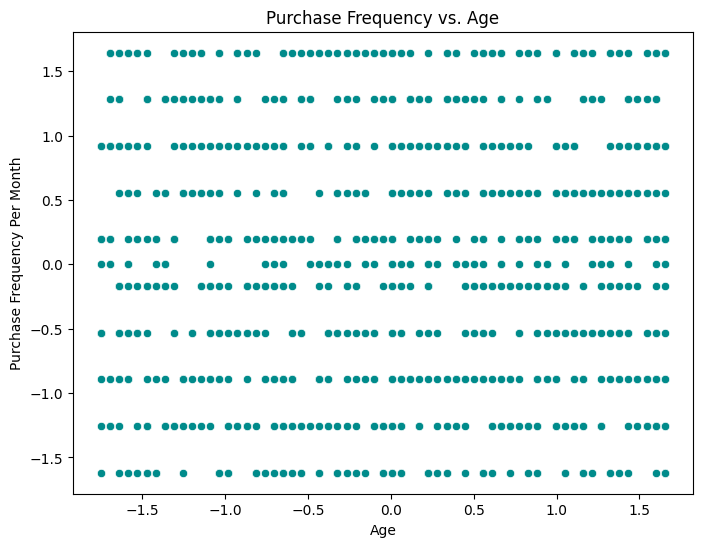

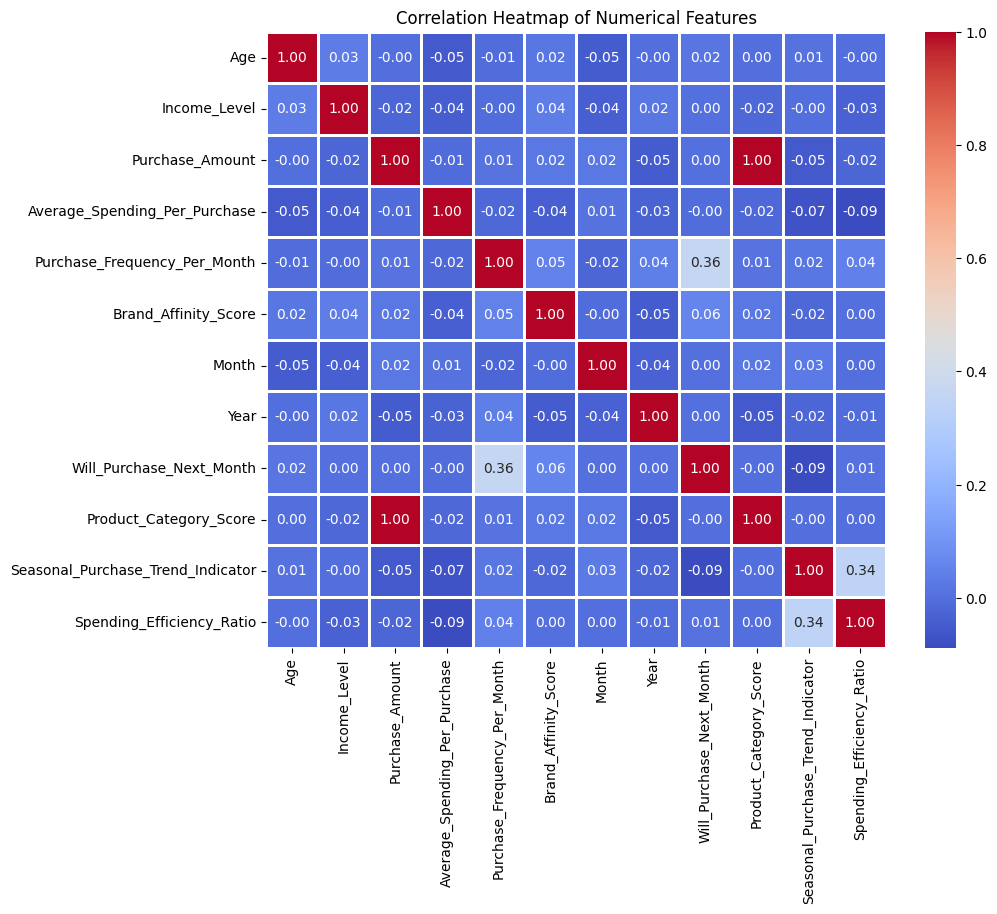


Correlation Matrix for Numerical Variables:
                                        Age  Income_Level  Purchase_Amount  \
Age                                1.000000      0.033362        -0.002557   
Income_Level                       0.033362      1.000000        -0.021282   
Purchase_Amount                   -0.002557     -0.021282         1.000000   
Average_Spending_Per_Purchase     -0.051478     -0.042066        -0.011514   
Purchase_Frequency_Per_Month      -0.006791     -0.004352         0.011903   
Brand_Affinity_Score               0.019694      0.036703         0.022211   
Month                             -0.048213     -0.038188         0.022433   
Year                              -0.001537      0.018477        -0.049535   
Will_Purchase_Next_Month           0.016094      0.001329         0.002112   
Product_Category_Score             0.000177     -0.018746         0.997738   
Seasonal_Purchase_Trend_Indicator  0.007693     -0.002090        -0.050656   
Spending_Efficiency

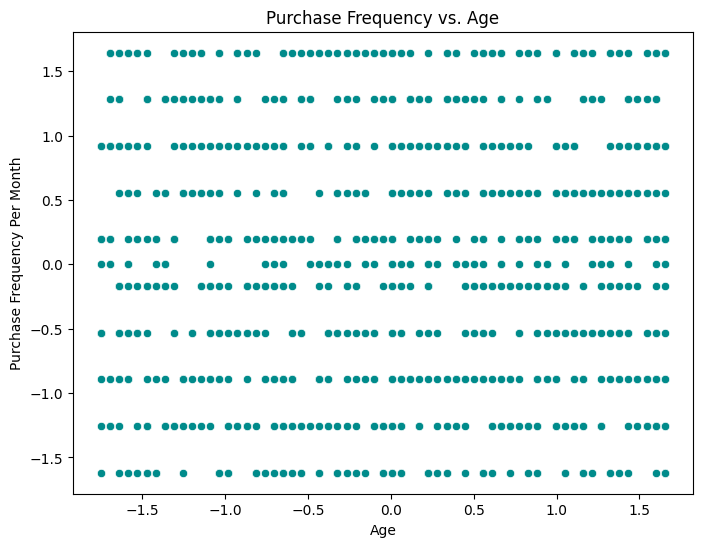

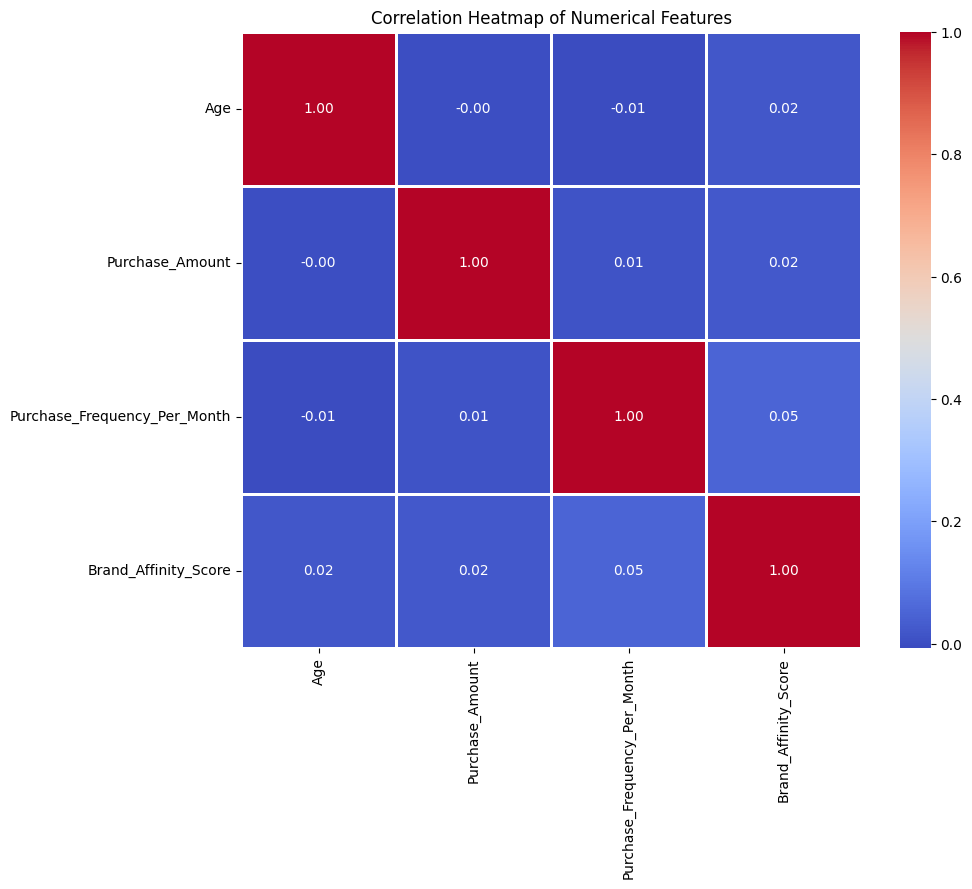


Correlation Matrix for Numerical Variables:
                                   Age  Purchase_Amount  \
Age                           1.000000        -0.002557   
Purchase_Amount              -0.002557         1.000000   
Purchase_Frequency_Per_Month -0.006791         0.011903   
Brand_Affinity_Score          0.019694         0.022211   

                              Purchase_Frequency_Per_Month  \
Age                                              -0.006791   
Purchase_Amount                                   0.011903   
Purchase_Frequency_Per_Month                      1.000000   
Brand_Affinity_Score                              0.050468   

                              Brand_Affinity_Score  
Age                                       0.019694  
Purchase_Amount                           0.022211  
Purchase_Frequency_Per_Month              0.050468  
Brand_Affinity_Score                      1.000000  


In [52]:
# 2. Bivariate Analysis: Explore Relationships Between Features

# Scatterplot for Purchase Amount vs. Income Level
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Purchase_Amount'], y=df['Income_Level'], color='purple')
plt.title('Purchase Amount vs. Income Level')
plt.xlabel('Purchase Amount')
plt.ylabel('Income Level')
plt.show()# 2. Bivariate Analysis: Explore Relationships Between Features

# Scatterplot for Purchase Amount vs. Income Level
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Purchase_Amount'], y=df['Income_Level'], color='purple')
plt.title('Purchase Amount vs. Income Level')
plt.xlabel('Purchase Amount')
plt.ylabel('Income Level')
plt.show()

# Boxplot for Brand Affinity Score vs. Product Category (using one-hot encoded columns)
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Product_Category_Electronics'], y=df['Brand_Affinity_Score'], palette='Set2')
plt.title('Brand Affinity Score vs. Product Category (Electronics)')
plt.xlabel('Product Category: Electronics')
plt.ylabel('Brand Affinity Score')
plt.show()

# Scatterplot for Purchase Frequency vs. Age
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Age'], y=df['Purchase_Frequency_Per_Month'], color='darkcyan')
plt.title('Purchase Frequency vs. Age')
plt.xlabel('Age')
plt.ylabel('Purchase Frequency Per Month')
plt.show()

# Correlation Heatmap (after encoding) to analyze relationships
corr = df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Checking for any highly correlated features that might indicate multicollinearity
print("\nCorrelation Matrix for Numerical Variables:")
print(corr)




# Scatterplot for Purchase Frequency vs. Age
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Age'], y=df['Purchase_Frequency_Per_Month'], color='darkcyan')
plt.title('Purchase Frequency vs. Age')
plt.xlabel('Age')
plt.ylabel('Purchase Frequency Per Month')
plt.show()

# Heatmap for correlations between numerical features
corr = df[numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Checking for any highly correlated features that might indicate multicollinearity
print("\nCorrelation Matrix for Numerical Variables:")
print(corr)


In [51]:
df.head()

,Customer_ID,Age,Gender,Income_Level,Address,Transaction_ID,Purchase_Date,Product_ID,Brand,Purchase_Amount,...,Product_Category_Score,Seasonal_Purchase_Trend_Indicator,Spending_Efficiency_Ratio,Product_Category_Books,Product_Category_Clothing,Product_Category_Electronics,Product_Category_Hidden,Season_Spring,Season_Summer,Season_Winter
0,b81ee6c9-2ae4-48a7-b283-220eaa244f43,-0.540511,Female,4,"43548 Murray Islands Suite 974\nAmyberg, CT 13457",c6a6c712-e36b-406a-bfde-f53bdcf4744f,2022-04-26,d2f767d6-b01a-41a2-87f7-ec1d1186f50e,Brand_C,-0.413109,...,-0.462696,0,-1.095497,False,True,False,False,False,False,True
1,,-1.362765,Male,2,,0b587838-1e4f-4231-b488-42bcd47c052a,2021-08-10,79eadc55-2de1-41cf-b1b6-40118c0bf8ec,Brand_A,0.491714,...,0.466227,0,0.378259,True,False,False,False,False,False,False
2,fdf79bcd-5908-4c90-8501-570ffb5b7648,0.391377,Other,3,"79683 Kevin Hill Apt. 555\nJohnshire, AR 39961",462925b1-a5bf-4996-bda2-59749de64eea,2021-12-09,9ab75a68-4329-4bd9-a259-2233c0f34c93,Brand_A,-0.384154,...,-0.328144,1,0.464564,False,False,True,False,False,False,True
3,878dccba-893a-48f9-8d34-6ed394fa3c9c,-0.650145,Female,4,02998 Hall Meadows Suite 809\nNorth Robertvill...,3cfafa02-6b34-4d77-9e05-d223dfab64e8,2022-12-03,d518569b-ff79-494b-b2b6-7e2af39db86a,Brand_C,0.086354,...,0.019600,0,-1.095497,False,True,False,False,False,False,False
4,0af0bd81-73cc-494e-aa5e-75c6d0b6d743,0.994363,Other,4,"21411 Timothy Ford Apt. 320\nDavisborough, AR ...",0d8dc27a-0c8f-4a82-b57e-8bf54cee9759,2020-06-08,b6deac9d-2b7e-4a51-8273-a6534910b3bc,Brand_B,1.295197,...,1.261362,0,0.378259,True,False,False,False,False,True,False


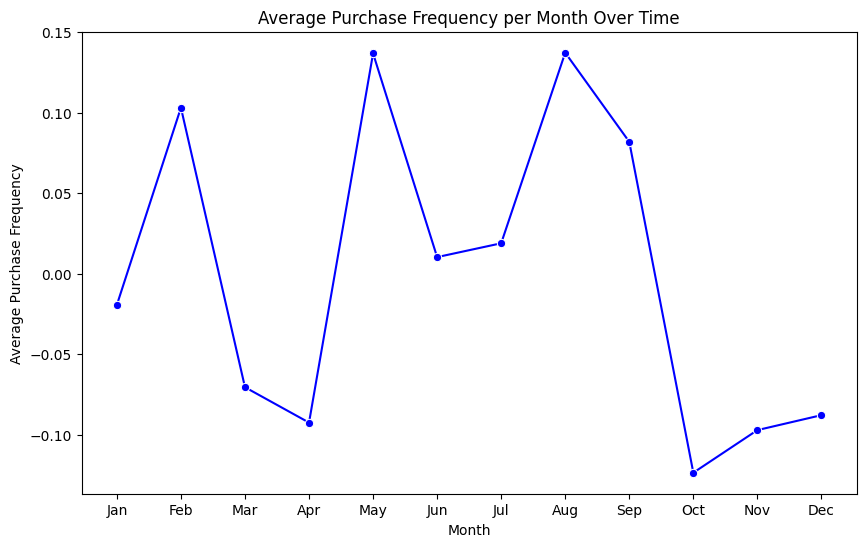

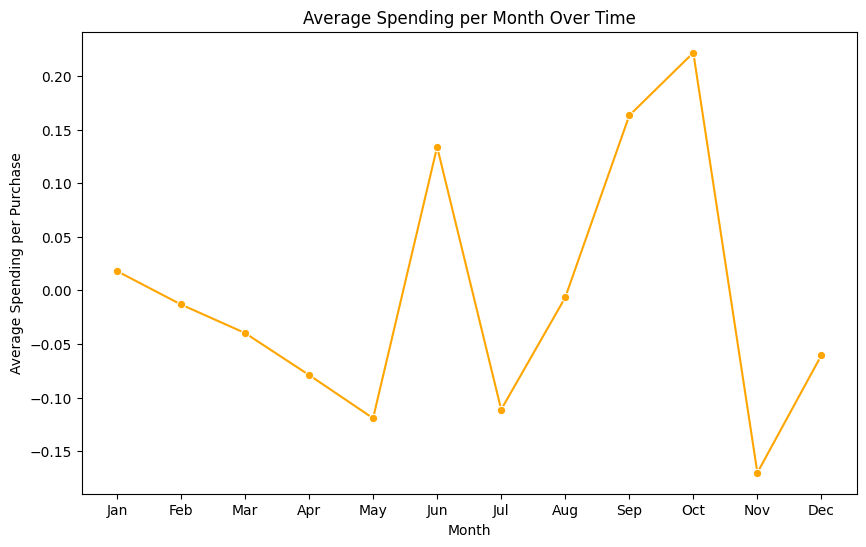

C:\Users\Muneeb\AppData\Local\Temp\ipykernel_6548\2671922712.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=seasonal_trends.index, y=seasonal_trends.values, palette='coolwarm')


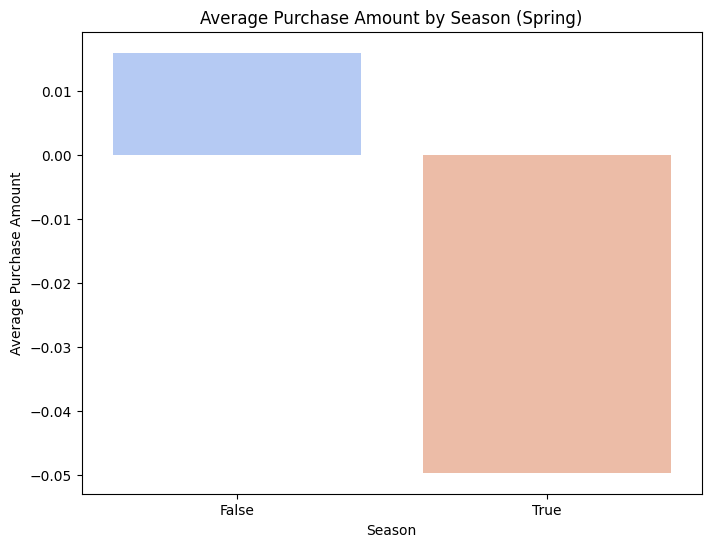

<Figure size 1200x800 with 0 Axes>

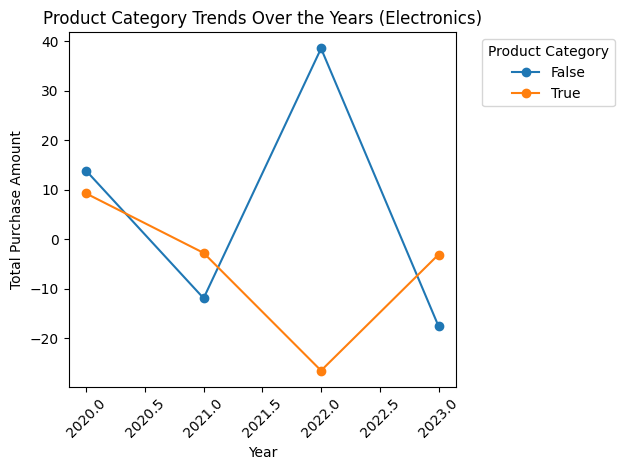

In [54]:
# 3. Temporal Analysis: Trends Over Time

# Assuming 'Year' and 'Month' are still present, let's visualize trends:

# Trend in Purchase Frequency over Time (by Year)
monthly_purchase_freq = df.groupby('Month')['Purchase_Frequency_Per_Month'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_purchase_freq.index, y=monthly_purchase_freq.values, color='b', marker='o')
plt.title('Average Purchase Frequency per Month Over Time')
plt.xlabel('Month')
plt.ylabel('Average Purchase Frequency')
plt.xticks(ticks=np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Trend in Average Spending per Month (by Year)
monthly_spending = df.groupby('Month')['Average_Spending_Per_Purchase'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_spending.index, y=monthly_spending.values, color='orange', marker='o')
plt.title('Average Spending per Month Over Time')
plt.xlabel('Month')
plt.ylabel('Average Spending per Purchase')
plt.xticks(ticks=np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Seasonal Variations in Product Category Preferences (using one-hot encoded columns)
seasonal_trends = df.groupby('Season_Spring')['Purchase_Amount'].mean()

plt.figure(figsize=(8, 6))
sns.barplot(x=seasonal_trends.index, y=seasonal_trends.values, palette='coolwarm')
plt.title('Average Purchase Amount by Season (Spring)')
plt.xlabel('Season')
plt.ylabel('Average Purchase Amount')
plt.show()

# Overall trend in Product Category Purchases over the years (to identify shifts in preference)
category_trends = df.groupby(['Year', 'Product_Category_Electronics'])['Purchase_Amount'].sum().unstack()

plt.figure(figsize=(12, 8))
category_trends.plot(kind='line', marker='o', title='Product Category Trends Over the Years (Electronics)')
plt.xlabel('Year')
plt.ylabel('Total Purchase Amount')
plt.xticks(rotation=45)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd

# Load the dataset
file_path = 'cleaned_data.csv'
cleaned_data = pd.read_csv(file_path)

# Display the first few rows of the dataset to inspect it
cleaned_data.head(), cleaned_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Customer_ID                              337 non-null    object 
 1   Age                                      346 non-null    float64
 2   Gender                                   346 non-null    int64  
 3   Income_Level                             346 non-null    int64  
 4   Transaction_ID                           335 non-null    object 
 5   Purchase_Date                            343 non-null    object 
 6   Product_ID                               335 non-null    object 
 7   Product_Category                         346 non-null    int64  
 8   Brand                                    346 non-null    int64  
 9   Purchase_Amount                          346 non-null    float64
 10  Average_Spending_Per_Purchase            346 non-n

(                            Customer_ID   Age  Gender  Income_Level  \
 0  fdf79bcd-5908-4c90-8501-570ffb5b7648  0.63       2             0   
 1  2e74b84d-d06c-4920-a3a9-38e4a11e8da8  0.58       0             2   
 2  309ab6ee-9364-4a64-9785-77717415ed5f  0.06       0             2   
 3  ffb65cd7-4329-4abb-b076-05eb7cf933e0  0.81       1             1   
 4  34f7ac8d-fd91-4813-bf4d-e7b18264e442  0.89       1             2   
 
                          Transaction_ID Purchase_Date  \
 0  462925b1-a5bf-4996-bda2-59749de64eea    2021-12-09   
 1  4c45da65-bd62-486e-aeff-31f8959e0987    2023-06-03   
 2  62001db5-24fa-49d8-b570-928124a181d9    2022-01-07   
 3  27a18611-855f-4db3-ad4e-77b008695f09    2022-06-25   
 4  b6c5589a-483a-403f-9cf2-b0ae77b15fbf    2021-11-27   
 
                              Product_ID  Product_Category  Brand  \
 0  9ab75a68-4329-4bd9-a259-2233c0f34c93                 0      0   
 1  e47f58c8-c6e9-40ed-9ce8-31af73b91fb5                 0      1   
 2  b66ca

# Decision Tree Classifier

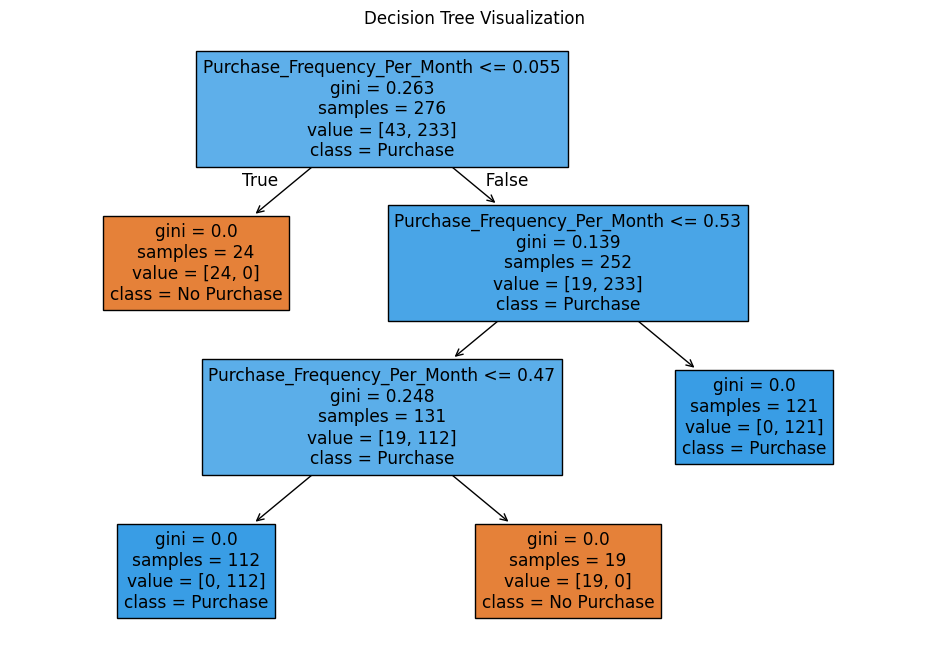

(1.0, np.float64(1.0), np.float64(1.0), np.float64(1.0))

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree
import matplotlib.pyplot as plt


# Selecting features and target variable
features = ['Purchase_Frequency_Per_Month', 'Average_Spending_Per_Purchase', 
            'Brand_Affinity_Score', 'Recency_Score']
target = 'Will_Purchase_Next_Month'

X = cleaned_data[features]
y = cleaned_data[target]

# Splitting the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the Decision Tree Classifier
clf = DecisionTreeClassifier(criterion='gini', random_state=42)
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Plotting the decision tree
plt.figure(figsize=(12, 8))
tree.plot_tree(clf, feature_names=features, class_names=['No Purchase', 'Purchase'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

accuracy, precision, recall, f1


Metrics using Entropy:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


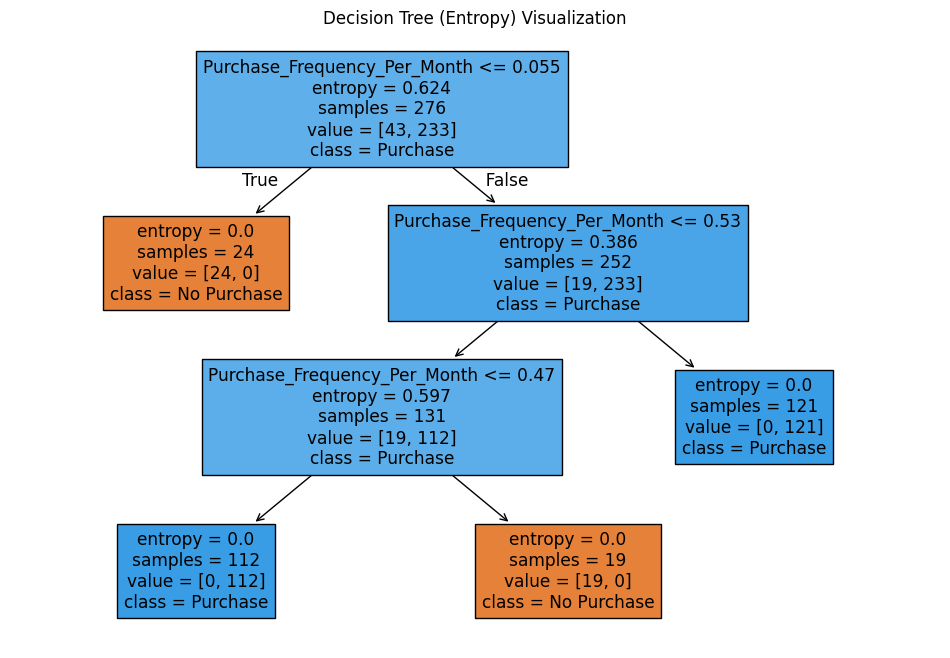

Feature Importances: {'Purchase_Frequency_Per_Month': np.float64(1.0), 'Average_Spending_Per_Purchase': np.float64(0.0), 'Brand_Affinity_Score': np.float64(0.0), 'Recency_Score': np.float64(0.0)}


In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree
import matplotlib.pyplot as plt

# Step 1: Load and Prepare Data
# Replace 'features' and 'target' with the appropriate columns from your dataset
features = ['Purchase_Frequency_Per_Month', 'Average_Spending_Per_Purchase', 
            'Brand_Affinity_Score', 'Recency_Score']
target = 'Will_Purchase_Next_Month'

X = cleaned_data[features]
y = cleaned_data[target]

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train Decision Tree with Entropy
clf_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf_entropy.fit(X_train, y_train)

# Step 4: Evaluate the Model
y_pred = clf_entropy.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Metrics using Entropy:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Step 5: Visualize the Decision Tree
plt.figure(figsize=(12, 8))
tree.plot_tree(clf_entropy, feature_names=features, class_names=['No Purchase', 'Purchase'], filled=True)
plt.title("Decision Tree (Entropy) Visualization")
plt.show()

# Step 6: Highlight Important Features
feature_importances = clf_entropy.feature_importances_
important_features = dict(zip(features, feature_importances))
print("Feature Importances:", important_features)


# Clustering

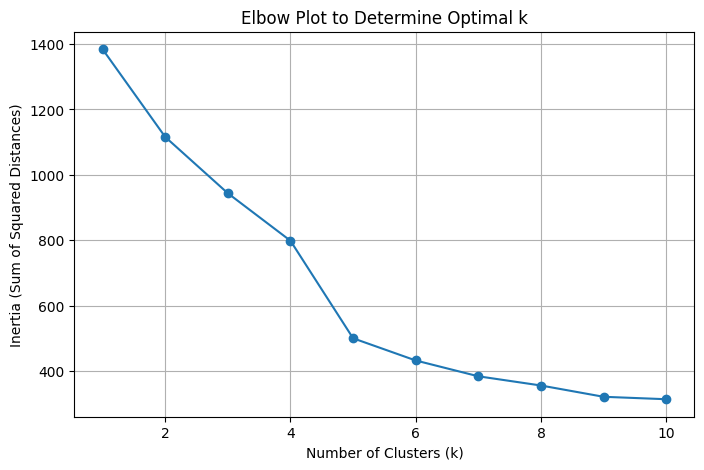

Cluster Summary:
         Purchase_Frequency_Per_Month  Average_Spending_Per_Purchase  \
Cluster                                                                
0                            0.371981                       0.296698   
1                            0.226933                       0.746667   
2                            0.831412                       0.621059   
3                            0.570000                       0.260500   

         Brand_Affinity_Score  Recency_Score  Customer_Count  
Cluster                                                       
0                    0.747075          2.000             106  
1                    0.280133          2.000              75  
2                    0.580824          2.000              85  
3                    0.210000          1.725              80  


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
file_path = 'cleaned_data.csv'
data = pd.read_csv(file_path)
# Step 1: Load the Data
# Assume `cleaned_data` is your dataframe
# Remove the target variable (predicted label) for unsupervised learning
features = ['Purchase_Frequency_Per_Month', 'Average_Spending_Per_Purchase', 
            'Brand_Affinity_Score', 'Recency_Score']
X = data[features]

# Step 2: Standardize the Data
# Explanation: K-Means is distance-based, so features should have comparable scales.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Determine the Optimal Number of Clusters (k) using the Elbow Method
# Explanation: We calculate the sum of squared distances (inertia) for different k values
# and plot them to identify the "elbow point," where the decrease in inertia slows down.
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Plot to Determine Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.grid()
plt.show()

# Step 4: Choose the Optimal k
# After observing the elbow plot, 
optimal_k = 4

# Step 5: Apply K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original dataframe for analysis
cleaned_data['Cluster'] = clusters

# Step 6: Analyze Cluster Characteristics
# Explanation: Group data by clusters and compute statistics for key features
cluster_summary = cleaned_data.groupby('Cluster').agg({
    'Purchase_Frequency_Per_Month': 'mean',
    'Average_Spending_Per_Purchase': 'mean',
    'Brand_Affinity_Score': 'mean',
    'Recency_Score': 'mean',
    'Cluster': 'count'  # Count of customers in each cluster
}).rename(columns={'Cluster': 'Customer_Count'})

print("Cluster Summary:")
print(cluster_summary)


# Step 7: Identify Differences Between Clusters
# Explanation: From the cluster summary, compare averages to see how clusters differ
# in behaviors like spending patterns, brand affinity, etc.


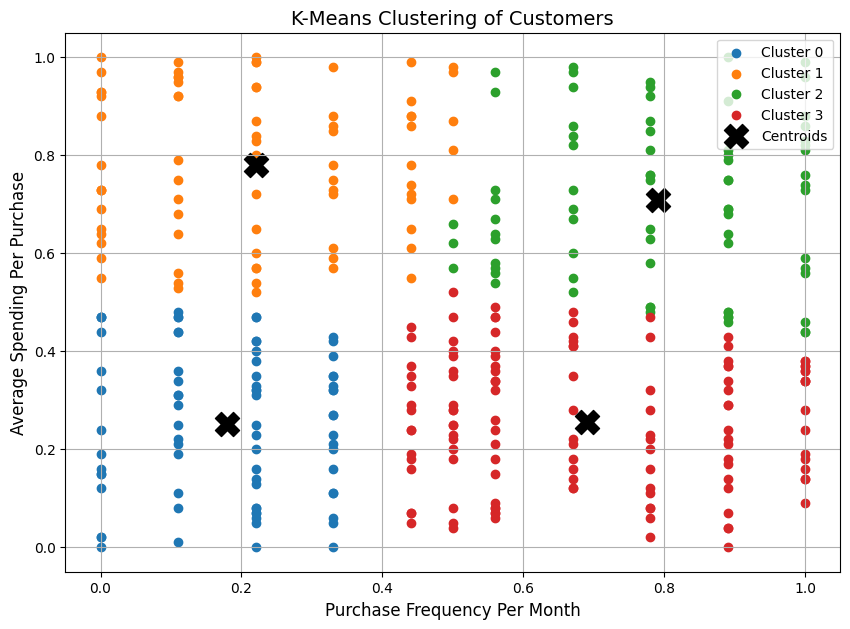

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select features for clustering
features = ['Purchase_Frequency_Per_Month', 'Average_Spending_Per_Purchase']
X = cleaned_data[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering
optimal_k = 4  # Assuming clusters based on the elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataset
cleaned_data['Cluster'] = clusters

# Scatter plot to show data points colored by cluster
plt.figure(figsize=(10, 7))

# Loop through each cluster and plot the points
for cluster in range(optimal_k):
    cluster_data = cleaned_data[cleaned_data['Cluster'] == cluster]
    plt.scatter(
        cluster_data['Purchase_Frequency_Per_Month'], 
        cluster_data['Average_Spending_Per_Purchase'], 
        label=f'Cluster {cluster}'
    )

# Plot the centroids for visual clarity
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(
    centroids[:, 0], centroids[:, 1], 
    s=300, c='black', marker='X', label='Centroids'
)

# Add labels, title, and legend
plt.title("K-Means Clustering of Customers", fontsize=14)
plt.xlabel("Purchase Frequency Per Month", fontsize=12)
plt.ylabel("Average Spending Per Purchase", fontsize=12)
plt.legend()
plt.grid()
plt.show()
